In [46]:
import os
import argparse
import networkx as nx
import math        
import numpy as np
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time

def get_rval(x):
    tmp = randint(0,99)
    if tmp%2:
        return randint(0,x-1)
    else:
        return randint(x+1,9)

def get_rval2(x):
    x1 = get_rval(x)
    x2 = get_rval(x)
    while abs(x1-x2)==1:
        x1 = get_rval(x)
        x2 = get_rval(x)
    return x1, x2

def get_random_occ_grid():
    row1 = randint(1,8)
    row2 = randint(1,8)
    while(row2 == row1 and row2 == row1 - 1 and row2 == row1 + 1):
        row2 = randint(1,8)
    col = randint(2,7)

    rc1, rc2 = get_rval2(col)
    cr1_1, cr1_2 = get_rval2(row1)
    cr2_1, cr2_2 = get_rval2(row2)

    occ_grid = np.ones((10,10))
    
    for i in range(10):
        if not (i==cr1_1 or i==cr1_2):
            occ_grid[row1,i] = 0

        if not (i==rc1 or i==rc2):
            occ_grid[i,col] = 0
            
        if not (i==cr2_1 or i==cr2_2):
            occ_grid[row2,i] = 0
            
            
    return occ_grid, row1, col



# Generating "DOF" definition of Landmark

In [2]:
total_data = 50
for num_data in range(total_data):
    occ_g, row1, col = get_random_occ_grid()
    data = occ_g.reshape(100)
    #fig1 = plt.figure(figsize=(10,6), dpi=80)
    #ax1 = fig1.add_subplot(111, aspect = 'equal')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    num_landmark = 1000
    num_neighbor = 200
    radius_landmark = 0.7
    #landmark = np.zeros((num_landmark, 2))
    #graph = nx.Graph()
    cnt = 0
    for i in range(num_landmark):
        x = np.random.uniform(0, 10)
        y = np.random.uniform(0, 10)
        if occ_g[int(x)][int(y)] == 0:
            continue

        ratio = 0.0
        minus = 0.0
        for j in range(num_neighbor):
            r = np.random.uniform(0, radius_landmark)
            theta = np.random.uniform(0, 2*np.pi)
            x_ = x + r * np.cos(theta)
            y_ = y + r * np.sin(theta)
            if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
                minus += 1
                continue
            if occ_g[int(x_)][int(y_)] == 1:
                ratio += 1
        ratio = ratio / (num_neighbor - minus)
        #graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
        if ratio <= 0.9:
            #print(ratio)
            data = np.append(data,x)
            data = np.append(data,y)
            #plt.scatter(x/10, y/10, color = 'blue', s = 10)
    '''
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))
    plt.show()
    '''
    print(num_data, data.shape)
    np.save('/home/zhizuo/lego/dataset/landmark_{}'.format(str(num_data)),data)

0 (410,)
1 (470,)
2 (352,)
3 (500,)
4 (424,)
5 (464,)
6 (510,)
7 (522,)
8 (484,)
9 (518,)
10 (516,)
11 (484,)
12 (478,)
13 (458,)
14 (370,)
15 (490,)
16 (490,)
17 (474,)
18 (490,)
19 (442,)
20 (346,)
21 (384,)
22 (388,)
23 (462,)
24 (502,)
25 (390,)
26 (498,)
27 (466,)
28 (318,)
29 (376,)
30 (474,)
31 (476,)
32 (468,)
33 (362,)
34 (472,)
35 (492,)
36 (352,)
37 (394,)
38 (510,)
39 (368,)
40 (382,)
41 (498,)
42 (434,)
43 (332,)
44 (382,)
45 (480,)
46 (482,)
47 (458,)
48 (486,)
49 (414,)


In [47]:
import torch.nn as nn
import torch.nn.functional as F


# =======================
# CVAE (MLP version)
# =======================
class CVAE_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
        self.fc1 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x, c):
        inputs = torch.cat((x, c), 1)
        outputs = self.encoder(inputs)
        z_mu = self.fc1(outputs)
        z_logvar = self.fc2(outputs)
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        
        inputs_1 = torch.cat((z,c), 1)
        
        outputs_1 = self.decoder(inputs_1)
        return z_mu, z_logvar, outputs_1

In [100]:
import torch.nn as nn
import torch.nn.functional as F

# =======================
# CVAE (CNN version)
# =======================
class CVAE_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        def c_block(in_filters, out_filters, kernel_size = 3, stride = 1, padding = 1, bn=False):
            if bn:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.BatchNorm2d(out_filters),
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            else:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            return block
        
        #self.deconv_en = nn.ConvTranspose2d(2,1,10, stride = 1, padding=0)
        #self.decon_de = nn.ConvTranspose2d(2,1,10, stride = 1, padding = 0)
        
        # ====================
        # Encoder part
        # ====================
        self.deconv_en = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.encoder = nn.Sequential(
            *c_block(7,   16, 3, 2, 1),
            *c_block(16,  32, 3, 1, 0),
            *c_block(32,  64, 3, 1, 0),
        )
        
        self.mu_mlp = nn.Linear(64, 2)
        self.logvar_mlp = nn.Linear(64, 2)
        
        # ====================
        # Decoder part
        # ====================
        self.deconv_de = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.decoder = nn.Sequential(
            *c_block(7,   16, 3, 2, 1),
            *c_block(16,  32, 3, 1, 0),
            *c_block(32,  64, 3, 1, 0),
        )
        
        self.predict_mlp = nn.Linear(64, 2)
        
        
    def forward(self, x, c):
        # Encoder
        x = x.view(x.shape[0], 2, 1, -1)
        cat = c[:, 0:4]
        cat = cat.view(cat.shape[0], 4, 1, -1)
        x_en = torch.cat((x, cat), 1)
        c_en = c[:, 4:].view(c.shape[0], 1, 10, -1)
        deconv_x = self.deconv_en(x_en)
        input_en = torch.cat((deconv_x, c_en), 1)
        output_en = self.encoder(input_en)
        output_en = output_en.view(output_en.shape[0], 1, 64)
        z_mu = self.mu_mlp(output_en)
        z_logvar = self.logvar_mlp(output_en)

        
        # Latent space
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        z = z.view(z.shape[0], 2, 1, -1)
        # Decoder 
        z = torch.cat((z, cat), 1)
        z_deconv = self.deconv_de(z)
        input_decoder = torch.cat((z_deconv,c_en), 1)
        output_decoder = self.decoder(input_decoder)
        output_decoder = output_decoder.view(output_decoder.shape[0], 1, 64)
        predict = self.predict_mlp(output_decoder)
        predict = predict.view(predict.shape[0],-1)
        return z_mu, z_logvar, predict

    
def KL_loss(z_mu, z_logvar):
    return 2 * torch.sum(torch.exp(z_logvar) + 
                        z_mu**2 - 1. - z_logvar, dim=1).mean()
def Recon_loss(labels, predictions):
    loss = nn.MSELoss()
    return loss(labels, predictions)



In [93]:
import argparse
from torch import optim
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()
parser.add_argument("--max_epochs", type=int, default=2000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--eps", type=float, default=1e-8, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
#parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
#parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
#parser.add_argument("--channels", type=int, default=1, help="number of image channels")
#parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

landmark_data = []
total_data = 50
for i in range(total_data):
    data = np.load('/home/zhizuo/lego/dataset/landmark_{}.npy'.format(str(i)))
    length = data.shape[0]
    for j in range(int((length - 100)/2)) :
        tmp = np.concatenate((data[0:100], data[(100+j*2):(100+j*2+2)]))
        landmark_data.append(tmp)
        
landmark_data = np.array(landmark_data)
print(landmark_data.shape)
    
class LandmarkSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)
    



Namespace(b1=0.9, b2=0.999, batch_size=128, eps=1e-08, lr=0.0001, max_epochs=2000, n_cpu=8)
(8596, 102)


# Train for Lego Dataset

In [143]:
from torch.utils.data import Dataset, DataLoader
import networkx as nx
from process_it import process_it

# ==============================
# Lego shortest path dataset
# ==============================

class LegoSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)

    
G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset"

directory = data_dir
print(directory)
data = np.array(process_it(G, directory))
print("shape of array: ", data.shape)
numEntries = data.shape[0]
dim = 2
dataElements = dim * 3 + 10 * 10
z_dim = 2
X_dim = dim
y_dim = dim
ratioTestTrain = 0.8
numTrain = int(numEntries * ratioTestTrain)
X_train = data[0:numTrain, 0:dim]
c_train = data[0:numTrain, dim:dataElements]

X_test = data[numTrain:numEntries, 0:dim]
c_test = data[numTrain:numEntries, dim:dataElements]

path = "/Users/zhangzhizuo/Desktop/UCSD/Su Lab/Code Lego/"
train_data = LegoSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
test_data = LegoSet(x = X_test, c = c_test, train = False)
test_loader = DataLoader(test_data, batch_size = opt.batch_size, shuffle = False)

net = CVAE_CNN()
resume = "./Model/CVAE_CNN_2020_3_19_21.pkl"
if resume == None:
    net = CVAE_CNN()
else:
    net.load_state_dict(torch.load(resume))
    
if torch.cuda.is_available():
    net.cuda()
net.train()
optimizer = optimizer = optim.Adam(net.parameters(), lr=opt.lr, 
                      betas=(opt.b1, opt.b2), eps=1e-08, weight_decay=0)

for epoch in range(opt.max_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0
    epoch_loss = 0.0
    for x, c in train_loader:
        i += 1
        batch_elements = [randint(0, numTrain - 1)
                         for n in range(0, 256)]
        
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-4
        #if epoch >= 100:
        #    beta = 10 ** -4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss += loss
        if i % 500 == 0:
            print("Epoch {} Batch {} loss: KL = {:.8f}, Recon = {:.6f}, Loss = {:.6f}".
              format(epoch + 1, i, kl_loss, recon_loss, loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / i
    print("Average loss of epoch {} is : Loss {:.8f} Recon {:.8f} KL {:.8f}".format(epoch + 1, epoch_loss, recon_loss, kl_loss))
    if (epoch + 1) % 1000 == 0 and epoch >= 99:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(), 
                  '/home/zhizuo/lego/Model/CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE")
net.eval()             


dataset
shape of array:  (21490, 106)
Starting the 1 epoch
Average loss of epoch 1 is : Loss 0.00193531 Recon 0.00149491 KL 9.55756378
Starting the 2 epoch
Average loss of epoch 2 is : Loss 0.00195124 Recon 0.00107792 KL 9.90987968
Starting the 3 epoch
Average loss of epoch 3 is : Loss 0.00195149 Recon 0.00087110 KL 9.49021435
Starting the 4 epoch
Average loss of epoch 4 is : Loss 0.00192246 Recon 0.00113134 KL 9.47710323
Starting the 5 epoch
Average loss of epoch 5 is : Loss 0.00192824 Recon 0.00089102 KL 9.41672039
Starting the 6 epoch
Average loss of epoch 6 is : Loss 0.00193455 Recon 0.00092149 KL 9.55340099
Starting the 7 epoch
Average loss of epoch 7 is : Loss 0.00194255 Recon 0.00099207 KL 9.78915787
Starting the 8 epoch
Average loss of epoch 8 is : Loss 0.00193294 Recon 0.00118192 KL 9.43751812
Starting the 9 epoch
Average loss of epoch 9 is : Loss 0.00195337 Recon 0.00098127 KL 9.31517220
Starting the 10 epoch
Average loss of epoch 10 is : Loss 0.00194414 Recon 0.00105705 KL 9

Average loss of epoch 84 is : Loss 0.00193287 Recon 0.00083401 KL 9.19869518
Starting the 85 epoch
Average loss of epoch 85 is : Loss 0.00193045 Recon 0.00110826 KL 9.24827099
Starting the 86 epoch
Average loss of epoch 86 is : Loss 0.00194515 Recon 0.00079530 KL 9.38374329
Starting the 87 epoch
Average loss of epoch 87 is : Loss 0.00194620 Recon 0.00104302 KL 9.40496349
Starting the 88 epoch
Average loss of epoch 88 is : Loss 0.00193652 Recon 0.00132008 KL 9.74454975
Starting the 89 epoch
Average loss of epoch 89 is : Loss 0.00193892 Recon 0.00091206 KL 9.79046917
Starting the 90 epoch
Average loss of epoch 90 is : Loss 0.00195000 Recon 0.00086761 KL 9.41984558
Starting the 91 epoch
Average loss of epoch 91 is : Loss 0.00193580 Recon 0.00116277 KL 9.60391712
Starting the 92 epoch
Average loss of epoch 92 is : Loss 0.00195115 Recon 0.00105181 KL 9.04986954
Starting the 93 epoch
Average loss of epoch 93 is : Loss 0.00192495 Recon 0.00107349 KL 9.53575230
Starting the 94 epoch
Average lo

Average loss of epoch 166 is : Loss 0.00194354 Recon 0.00077507 KL 9.35091686
Starting the 167 epoch
Average loss of epoch 167 is : Loss 0.00194693 Recon 0.00068389 KL 9.30953884
Starting the 168 epoch
Average loss of epoch 168 is : Loss 0.00194064 Recon 0.00111808 KL 9.80888271
Starting the 169 epoch
Average loss of epoch 169 is : Loss 0.00194619 Recon 0.00106652 KL 9.54622841
Starting the 170 epoch
Average loss of epoch 170 is : Loss 0.00193673 Recon 0.00095547 KL 9.94470978
Starting the 171 epoch
Average loss of epoch 171 is : Loss 0.00192261 Recon 0.00083632 KL 9.26051998
Starting the 172 epoch
Average loss of epoch 172 is : Loss 0.00194116 Recon 0.00110962 KL 9.37333965
Starting the 173 epoch
Average loss of epoch 173 is : Loss 0.00195105 Recon 0.00128362 KL 9.82270241
Starting the 174 epoch
Average loss of epoch 174 is : Loss 0.00193890 Recon 0.00114040 KL 9.68143368
Starting the 175 epoch
Average loss of epoch 175 is : Loss 0.00193004 Recon 0.00074543 KL 9.06981945
Starting the 

Average loss of epoch 248 is : Loss 0.00193427 Recon 0.00119501 KL 9.16409016
Starting the 249 epoch
Average loss of epoch 249 is : Loss 0.00192161 Recon 0.00075605 KL 9.01856995
Starting the 250 epoch
Average loss of epoch 250 is : Loss 0.00192940 Recon 0.00074100 KL 9.38103676
Starting the 251 epoch
Average loss of epoch 251 is : Loss 0.00192974 Recon 0.00094730 KL 9.10090923
Starting the 252 epoch
Average loss of epoch 252 is : Loss 0.00192383 Recon 0.00144967 KL 9.67244816
Starting the 253 epoch
Average loss of epoch 253 is : Loss 0.00192323 Recon 0.00088589 KL 9.43552494
Starting the 254 epoch
Average loss of epoch 254 is : Loss 0.00194441 Recon 0.00094770 KL 9.62048817
Starting the 255 epoch
Average loss of epoch 255 is : Loss 0.00191962 Recon 0.00144002 KL 9.42117214
Starting the 256 epoch
Average loss of epoch 256 is : Loss 0.00192651 Recon 0.00079569 KL 9.23247147
Starting the 257 epoch
Average loss of epoch 257 is : Loss 0.00192027 Recon 0.00100605 KL 9.56242180
Starting the 

Average loss of epoch 330 is : Loss 0.00193099 Recon 0.00151722 KL 9.26713562
Starting the 331 epoch
Average loss of epoch 331 is : Loss 0.00192144 Recon 0.00069727 KL 9.59349346
Starting the 332 epoch
Average loss of epoch 332 is : Loss 0.00193048 Recon 0.00080471 KL 9.53544903
Starting the 333 epoch
Average loss of epoch 333 is : Loss 0.00193294 Recon 0.00120940 KL 9.48775482
Starting the 334 epoch
Average loss of epoch 334 is : Loss 0.00193138 Recon 0.00110018 KL 9.76684570
Starting the 335 epoch
Average loss of epoch 335 is : Loss 0.00194671 Recon 0.00108776 KL 9.73608303
Starting the 336 epoch
Average loss of epoch 336 is : Loss 0.00193037 Recon 0.00091604 KL 9.50359154
Starting the 337 epoch
Average loss of epoch 337 is : Loss 0.00192284 Recon 0.00116726 KL 9.27546597
Starting the 338 epoch
Average loss of epoch 338 is : Loss 0.00191682 Recon 0.00062886 KL 9.03520107
Starting the 339 epoch
Average loss of epoch 339 is : Loss 0.00192476 Recon 0.00092224 KL 9.88587952
Starting the 

Average loss of epoch 412 is : Loss 0.00193538 Recon 0.00085680 KL 9.66626740
Starting the 413 epoch
Average loss of epoch 413 is : Loss 0.00193259 Recon 0.00079075 KL 9.09924030
Starting the 414 epoch
Average loss of epoch 414 is : Loss 0.00192469 Recon 0.00099982 KL 9.65010548
Starting the 415 epoch
Average loss of epoch 415 is : Loss 0.00191522 Recon 0.00085927 KL 9.47665310
Starting the 416 epoch
Average loss of epoch 416 is : Loss 0.00191916 Recon 0.00091129 KL 9.19761848
Starting the 417 epoch
Average loss of epoch 417 is : Loss 0.00192164 Recon 0.00123525 KL 9.20200920
Starting the 418 epoch
Average loss of epoch 418 is : Loss 0.00192464 Recon 0.00117679 KL 9.60846138
Starting the 419 epoch
Average loss of epoch 419 is : Loss 0.00192736 Recon 0.00116842 KL 10.04656506
Starting the 420 epoch
Average loss of epoch 420 is : Loss 0.00192938 Recon 0.00117717 KL 9.40284348
Starting the 421 epoch
Average loss of epoch 421 is : Loss 0.00190554 Recon 0.00065959 KL 9.07733822
Starting the

Average loss of epoch 494 is : Loss 0.00193178 Recon 0.00082745 KL 9.43469715
Starting the 495 epoch
Average loss of epoch 495 is : Loss 0.00194231 Recon 0.00127095 KL 9.42865944
Starting the 496 epoch
Average loss of epoch 496 is : Loss 0.00194719 Recon 0.00071148 KL 9.23987484
Starting the 497 epoch
Average loss of epoch 497 is : Loss 0.00194063 Recon 0.00074014 KL 8.95775890
Starting the 498 epoch
Average loss of epoch 498 is : Loss 0.00192487 Recon 0.00104330 KL 9.22550106
Starting the 499 epoch
Average loss of epoch 499 is : Loss 0.00193677 Recon 0.00113490 KL 9.44730949
Starting the 500 epoch
Average loss of epoch 500 is : Loss 0.00192265 Recon 0.00116039 KL 9.35557556
Starting the 501 epoch
Average loss of epoch 501 is : Loss 0.00191069 Recon 0.00073928 KL 9.40934086
Starting the 502 epoch
Average loss of epoch 502 is : Loss 0.00191570 Recon 0.00084847 KL 9.49937344
Starting the 503 epoch
Average loss of epoch 503 is : Loss 0.00193258 Recon 0.00105407 KL 9.29588318
Starting the 

Average loss of epoch 576 is : Loss 0.00193291 Recon 0.00119924 KL 9.59472942
Starting the 577 epoch
Average loss of epoch 577 is : Loss 0.00193340 Recon 0.00083580 KL 9.08813190
Starting the 578 epoch
Average loss of epoch 578 is : Loss 0.00191665 Recon 0.00093716 KL 9.50936317
Starting the 579 epoch
Average loss of epoch 579 is : Loss 0.00193050 Recon 0.00077782 KL 9.00741959
Starting the 580 epoch
Average loss of epoch 580 is : Loss 0.00191651 Recon 0.00083996 KL 9.31585121
Starting the 581 epoch
Average loss of epoch 581 is : Loss 0.00192290 Recon 0.00127111 KL 9.80733395
Starting the 582 epoch
Average loss of epoch 582 is : Loss 0.00190999 Recon 0.00107153 KL 9.88062572
Starting the 583 epoch
Average loss of epoch 583 is : Loss 0.00193867 Recon 0.00180527 KL 9.45459175
Starting the 584 epoch
Average loss of epoch 584 is : Loss 0.00193718 Recon 0.00082579 KL 9.83245087
Starting the 585 epoch
Average loss of epoch 585 is : Loss 0.00192344 Recon 0.00119416 KL 9.85497093
Starting the 

Average loss of epoch 658 is : Loss 0.00192133 Recon 0.00091447 KL 9.61438179
Starting the 659 epoch
Average loss of epoch 659 is : Loss 0.00191234 Recon 0.00114807 KL 9.42557716
Starting the 660 epoch
Average loss of epoch 660 is : Loss 0.00190792 Recon 0.00069972 KL 9.35074902
Starting the 661 epoch
Average loss of epoch 661 is : Loss 0.00193263 Recon 0.00079030 KL 9.25878048
Starting the 662 epoch
Average loss of epoch 662 is : Loss 0.00193465 Recon 0.00093065 KL 9.52549744
Starting the 663 epoch
Average loss of epoch 663 is : Loss 0.00192293 Recon 0.00112654 KL 9.51964855
Starting the 664 epoch
Average loss of epoch 664 is : Loss 0.00191524 Recon 0.00090065 KL 10.28233719
Starting the 665 epoch
Average loss of epoch 665 is : Loss 0.00193768 Recon 0.00122066 KL 9.69625759
Starting the 666 epoch
Average loss of epoch 666 is : Loss 0.00193632 Recon 0.00084919 KL 9.64917278
Starting the 667 epoch
Average loss of epoch 667 is : Loss 0.00191449 Recon 0.00094059 KL 9.12683392
Starting the

Average loss of epoch 740 is : Loss 0.00193149 Recon 0.00115802 KL 9.62916756
Starting the 741 epoch
Average loss of epoch 741 is : Loss 0.00193086 Recon 0.00093114 KL 9.08244228
Starting the 742 epoch
Average loss of epoch 742 is : Loss 0.00192445 Recon 0.00093092 KL 9.78052521
Starting the 743 epoch
Average loss of epoch 743 is : Loss 0.00191009 Recon 0.00075603 KL 9.42331791
Starting the 744 epoch
Average loss of epoch 744 is : Loss 0.00191407 Recon 0.00099125 KL 9.78735733
Starting the 745 epoch
Average loss of epoch 745 is : Loss 0.00191368 Recon 0.00087422 KL 9.34716988
Starting the 746 epoch
Average loss of epoch 746 is : Loss 0.00191232 Recon 0.00087114 KL 9.36202431
Starting the 747 epoch
Average loss of epoch 747 is : Loss 0.00191106 Recon 0.00100683 KL 9.25162411
Starting the 748 epoch
Average loss of epoch 748 is : Loss 0.00191558 Recon 0.00090522 KL 9.63818073
Starting the 749 epoch
Average loss of epoch 749 is : Loss 0.00190574 Recon 0.00086095 KL 9.09790611
Starting the 

Average loss of epoch 822 is : Loss 0.00191666 Recon 0.00072204 KL 9.45866585
Starting the 823 epoch
Average loss of epoch 823 is : Loss 0.00190968 Recon 0.00081139 KL 9.56124592
Starting the 824 epoch
Average loss of epoch 824 is : Loss 0.00190560 Recon 0.00064856 KL 9.06470203
Starting the 825 epoch
Average loss of epoch 825 is : Loss 0.00193789 Recon 0.00126474 KL 9.29048157
Starting the 826 epoch
Average loss of epoch 826 is : Loss 0.00192485 Recon 0.00110126 KL 9.22866917
Starting the 827 epoch
Average loss of epoch 827 is : Loss 0.00191827 Recon 0.00089830 KL 9.52065849
Starting the 828 epoch
Average loss of epoch 828 is : Loss 0.00192055 Recon 0.00134881 KL 9.37596416
Starting the 829 epoch
Average loss of epoch 829 is : Loss 0.00192432 Recon 0.00111689 KL 9.29923534
Starting the 830 epoch
Average loss of epoch 830 is : Loss 0.00191715 Recon 0.00089415 KL 9.27131462
Starting the 831 epoch
Average loss of epoch 831 is : Loss 0.00190999 Recon 0.00085214 KL 9.43425751
Starting the 

Average loss of epoch 904 is : Loss 0.00192390 Recon 0.00099374 KL 9.33091640
Starting the 905 epoch
Average loss of epoch 905 is : Loss 0.00192117 Recon 0.00128607 KL 9.18470287
Starting the 906 epoch
Average loss of epoch 906 is : Loss 0.00192641 Recon 0.00114039 KL 9.27000427
Starting the 907 epoch
Average loss of epoch 907 is : Loss 0.00192927 Recon 0.00098988 KL 9.63534164
Starting the 908 epoch
Average loss of epoch 908 is : Loss 0.00191542 Recon 0.00085146 KL 10.10555172
Starting the 909 epoch
Average loss of epoch 909 is : Loss 0.00192199 Recon 0.00102405 KL 9.40810108
Starting the 910 epoch
Average loss of epoch 910 is : Loss 0.00190438 Recon 0.00093522 KL 9.31246090
Starting the 911 epoch
Average loss of epoch 911 is : Loss 0.00190446 Recon 0.00080274 KL 9.39622211
Starting the 912 epoch
Average loss of epoch 912 is : Loss 0.00190627 Recon 0.00069453 KL 9.27637672
Starting the 913 epoch
Average loss of epoch 913 is : Loss 0.00190897 Recon 0.00071116 KL 9.42332172
Starting the

Average loss of epoch 986 is : Loss 0.00192608 Recon 0.00112411 KL 9.65045929
Starting the 987 epoch
Average loss of epoch 987 is : Loss 0.00192651 Recon 0.00098007 KL 9.60006809
Starting the 988 epoch
Average loss of epoch 988 is : Loss 0.00191863 Recon 0.00096873 KL 9.52757740
Starting the 989 epoch
Average loss of epoch 989 is : Loss 0.00190981 Recon 0.00075577 KL 9.92868328
Starting the 990 epoch
Average loss of epoch 990 is : Loss 0.00192437 Recon 0.00086889 KL 9.37515163
Starting the 991 epoch
Average loss of epoch 991 is : Loss 0.00191762 Recon 0.00127623 KL 9.81159878
Starting the 992 epoch
Average loss of epoch 992 is : Loss 0.00191166 Recon 0.00103362 KL 9.27995205
Starting the 993 epoch
Average loss of epoch 993 is : Loss 0.00190835 Recon 0.00076610 KL 9.00869560
Starting the 994 epoch
Average loss of epoch 994 is : Loss 0.00191081 Recon 0.00080228 KL 8.92814922
Starting the 995 epoch
Average loss of epoch 995 is : Loss 0.00192188 Recon 0.00066580 KL 9.54053020
Starting the 

Average loss of epoch 1066 is : Loss 0.00191278 Recon 0.00100799 KL 9.34965515
Starting the 1067 epoch
Average loss of epoch 1067 is : Loss 0.00190852 Recon 0.00072037 KL 9.65937901
Starting the 1068 epoch
Average loss of epoch 1068 is : Loss 0.00191256 Recon 0.00078791 KL 9.13454628
Starting the 1069 epoch
Average loss of epoch 1069 is : Loss 0.00189965 Recon 0.00126922 KL 10.63995838
Starting the 1070 epoch
Average loss of epoch 1070 is : Loss 0.00191850 Recon 0.00108050 KL 9.45115089
Starting the 1071 epoch
Average loss of epoch 1071 is : Loss 0.00191893 Recon 0.00083709 KL 9.49297523
Starting the 1072 epoch
Average loss of epoch 1072 is : Loss 0.00189640 Recon 0.00091280 KL 9.23504829
Starting the 1073 epoch
Average loss of epoch 1073 is : Loss 0.00191058 Recon 0.00097606 KL 9.46641064
Starting the 1074 epoch
Average loss of epoch 1074 is : Loss 0.00191266 Recon 0.00098775 KL 10.00306416
Starting the 1075 epoch
Average loss of epoch 1075 is : Loss 0.00192103 Recon 0.00133473 KL 9.2

Average loss of epoch 1146 is : Loss 0.00191264 Recon 0.00053794 KL 9.19792747
Starting the 1147 epoch
Average loss of epoch 1147 is : Loss 0.00190590 Recon 0.00075909 KL 9.57589626
Starting the 1148 epoch
Average loss of epoch 1148 is : Loss 0.00191941 Recon 0.00103502 KL 9.42740917
Starting the 1149 epoch
Average loss of epoch 1149 is : Loss 0.00192608 Recon 0.00051994 KL 9.15257549
Starting the 1150 epoch
Average loss of epoch 1150 is : Loss 0.00191375 Recon 0.00077707 KL 10.07927608
Starting the 1151 epoch
Average loss of epoch 1151 is : Loss 0.00192018 Recon 0.00075370 KL 9.79679298
Starting the 1152 epoch
Average loss of epoch 1152 is : Loss 0.00191483 Recon 0.00084771 KL 9.35517025
Starting the 1153 epoch
Average loss of epoch 1153 is : Loss 0.00191838 Recon 0.00089251 KL 9.48363781
Starting the 1154 epoch
Average loss of epoch 1154 is : Loss 0.00191600 Recon 0.00133929 KL 9.08148098
Starting the 1155 epoch
Average loss of epoch 1155 is : Loss 0.00192038 Recon 0.00100126 KL 9.57

Average loss of epoch 1226 is : Loss 0.00191765 Recon 0.00122621 KL 8.84036922
Starting the 1227 epoch
Average loss of epoch 1227 is : Loss 0.00191524 Recon 0.00072123 KL 9.29416370
Starting the 1228 epoch
Average loss of epoch 1228 is : Loss 0.00189959 Recon 0.00099703 KL 9.10469341
Starting the 1229 epoch
Average loss of epoch 1229 is : Loss 0.00190942 Recon 0.00087189 KL 9.74254322
Starting the 1230 epoch
Average loss of epoch 1230 is : Loss 0.00192212 Recon 0.00096123 KL 9.76136494
Starting the 1231 epoch
Average loss of epoch 1231 is : Loss 0.00190909 Recon 0.00104642 KL 9.19346809
Starting the 1232 epoch
Average loss of epoch 1232 is : Loss 0.00191329 Recon 0.00073674 KL 8.98911190
Starting the 1233 epoch
Average loss of epoch 1233 is : Loss 0.00192323 Recon 0.00114117 KL 9.88339138
Starting the 1234 epoch
Average loss of epoch 1234 is : Loss 0.00191831 Recon 0.00095334 KL 9.52544308
Starting the 1235 epoch
Average loss of epoch 1235 is : Loss 0.00191314 Recon 0.00082437 KL 9.226

Average loss of epoch 1306 is : Loss 0.00191229 Recon 0.00132657 KL 9.74670219
Starting the 1307 epoch
Average loss of epoch 1307 is : Loss 0.00189587 Recon 0.00067223 KL 9.80689526
Starting the 1308 epoch
Average loss of epoch 1308 is : Loss 0.00190322 Recon 0.00126690 KL 9.29821014
Starting the 1309 epoch
Average loss of epoch 1309 is : Loss 0.00190512 Recon 0.00097802 KL 9.57245159
Starting the 1310 epoch
Average loss of epoch 1310 is : Loss 0.00191703 Recon 0.00101957 KL 9.72377491
Starting the 1311 epoch
Average loss of epoch 1311 is : Loss 0.00192055 Recon 0.00112132 KL 9.68627357
Starting the 1312 epoch
Average loss of epoch 1312 is : Loss 0.00190167 Recon 0.00076330 KL 9.19535065
Starting the 1313 epoch
Average loss of epoch 1313 is : Loss 0.00189537 Recon 0.00081503 KL 9.65279675
Starting the 1314 epoch
Average loss of epoch 1314 is : Loss 0.00192076 Recon 0.00086624 KL 9.47298431
Starting the 1315 epoch
Average loss of epoch 1315 is : Loss 0.00189410 Recon 0.00077285 KL 9.463

Average loss of epoch 1386 is : Loss 0.00190583 Recon 0.00110469 KL 9.51358604
Starting the 1387 epoch
Average loss of epoch 1387 is : Loss 0.00189588 Recon 0.00102460 KL 9.70463562
Starting the 1388 epoch
Average loss of epoch 1388 is : Loss 0.00190521 Recon 0.00083451 KL 9.26502323
Starting the 1389 epoch
Average loss of epoch 1389 is : Loss 0.00191152 Recon 0.00098994 KL 9.23635578
Starting the 1390 epoch
Average loss of epoch 1390 is : Loss 0.00190070 Recon 0.00086758 KL 9.12068462
Starting the 1391 epoch
Average loss of epoch 1391 is : Loss 0.00191659 Recon 0.00086127 KL 9.26941586
Starting the 1392 epoch
Average loss of epoch 1392 is : Loss 0.00191692 Recon 0.00112666 KL 10.02371502
Starting the 1393 epoch
Average loss of epoch 1393 is : Loss 0.00190404 Recon 0.00082814 KL 9.93323517
Starting the 1394 epoch
Average loss of epoch 1394 is : Loss 0.00191578 Recon 0.00092866 KL 9.38155365
Starting the 1395 epoch
Average loss of epoch 1395 is : Loss 0.00190716 Recon 0.00097007 KL 9.48

Average loss of epoch 1466 is : Loss 0.00190097 Recon 0.00095313 KL 9.34156990
Starting the 1467 epoch
Average loss of epoch 1467 is : Loss 0.00190822 Recon 0.00066659 KL 9.64416027
Starting the 1468 epoch
Average loss of epoch 1468 is : Loss 0.00189539 Recon 0.00055345 KL 9.30909157
Starting the 1469 epoch
Average loss of epoch 1469 is : Loss 0.00189670 Recon 0.00067807 KL 9.45671654
Starting the 1470 epoch
Average loss of epoch 1470 is : Loss 0.00190800 Recon 0.00105977 KL 9.45861244
Starting the 1471 epoch
Average loss of epoch 1471 is : Loss 0.00192338 Recon 0.00120319 KL 9.08097363
Starting the 1472 epoch
Average loss of epoch 1472 is : Loss 0.00190503 Recon 0.00091319 KL 8.95575428
Starting the 1473 epoch
Average loss of epoch 1473 is : Loss 0.00189641 Recon 0.00111606 KL 9.74695587
Starting the 1474 epoch
Average loss of epoch 1474 is : Loss 0.00192817 Recon 0.00120564 KL 9.40740490
Starting the 1475 epoch
Average loss of epoch 1475 is : Loss 0.00187863 Recon 0.00108538 KL 9.346

Average loss of epoch 1546 is : Loss 0.00191029 Recon 0.00084037 KL 9.31576729
Starting the 1547 epoch
Average loss of epoch 1547 is : Loss 0.00193268 Recon 0.00170013 KL 9.22788715
Starting the 1548 epoch
Average loss of epoch 1548 is : Loss 0.00190646 Recon 0.00084667 KL 9.06346416
Starting the 1549 epoch
Average loss of epoch 1549 is : Loss 0.00191105 Recon 0.00103817 KL 9.38749599
Starting the 1550 epoch
Average loss of epoch 1550 is : Loss 0.00191070 Recon 0.00127770 KL 9.97613621
Starting the 1551 epoch
Average loss of epoch 1551 is : Loss 0.00189522 Recon 0.00095215 KL 9.45852184
Starting the 1552 epoch
Average loss of epoch 1552 is : Loss 0.00189369 Recon 0.00090306 KL 9.16174793
Starting the 1553 epoch
Average loss of epoch 1553 is : Loss 0.00190446 Recon 0.00107331 KL 9.41129971
Starting the 1554 epoch
Average loss of epoch 1554 is : Loss 0.00188923 Recon 0.00093445 KL 9.69348431
Starting the 1555 epoch
Average loss of epoch 1555 is : Loss 0.00190766 Recon 0.00069600 KL 9.468

Average loss of epoch 1626 is : Loss 0.00190099 Recon 0.00072291 KL 9.63814354
Starting the 1627 epoch
Average loss of epoch 1627 is : Loss 0.00190194 Recon 0.00126249 KL 9.06299877
Starting the 1628 epoch
Average loss of epoch 1628 is : Loss 0.00190589 Recon 0.00063273 KL 9.07666302
Starting the 1629 epoch
Average loss of epoch 1629 is : Loss 0.00190290 Recon 0.00089203 KL 9.45432949
Starting the 1630 epoch
Average loss of epoch 1630 is : Loss 0.00189970 Recon 0.00067008 KL 9.71353436
Starting the 1631 epoch
Average loss of epoch 1631 is : Loss 0.00188815 Recon 0.00115884 KL 9.68589973
Starting the 1632 epoch
Average loss of epoch 1632 is : Loss 0.00190106 Recon 0.00083002 KL 8.90083790
Starting the 1633 epoch
Average loss of epoch 1633 is : Loss 0.00192704 Recon 0.00048694 KL 9.12165928
Starting the 1634 epoch
Average loss of epoch 1634 is : Loss 0.00190577 Recon 0.00083449 KL 9.57324028
Starting the 1635 epoch
Average loss of epoch 1635 is : Loss 0.00189554 Recon 0.00104928 KL 9.679

Average loss of epoch 1706 is : Loss 0.00188829 Recon 0.00082303 KL 9.31278515
Starting the 1707 epoch
Average loss of epoch 1707 is : Loss 0.00188872 Recon 0.00086584 KL 9.28345013
Starting the 1708 epoch
Average loss of epoch 1708 is : Loss 0.00190593 Recon 0.00101255 KL 9.25872517
Starting the 1709 epoch
Average loss of epoch 1709 is : Loss 0.00188971 Recon 0.00111046 KL 9.45866871
Starting the 1710 epoch
Average loss of epoch 1710 is : Loss 0.00189050 Recon 0.00090866 KL 9.24772549
Starting the 1711 epoch
Average loss of epoch 1711 is : Loss 0.00191237 Recon 0.00086097 KL 9.77389050
Starting the 1712 epoch
Average loss of epoch 1712 is : Loss 0.00190154 Recon 0.00089667 KL 9.51953888
Starting the 1713 epoch
Average loss of epoch 1713 is : Loss 0.00191107 Recon 0.00080663 KL 9.90807629
Starting the 1714 epoch
Average loss of epoch 1714 is : Loss 0.00190693 Recon 0.00112708 KL 9.38065910
Starting the 1715 epoch
Average loss of epoch 1715 is : Loss 0.00189972 Recon 0.00136005 KL 9.279

Average loss of epoch 1786 is : Loss 0.00189806 Recon 0.00074210 KL 9.62880993
Starting the 1787 epoch
Average loss of epoch 1787 is : Loss 0.00188635 Recon 0.00088355 KL 9.49147320
Starting the 1788 epoch
Average loss of epoch 1788 is : Loss 0.00191926 Recon 0.00094611 KL 9.52323627
Starting the 1789 epoch
Average loss of epoch 1789 is : Loss 0.00189958 Recon 0.00115961 KL 9.18447018
Starting the 1790 epoch
Average loss of epoch 1790 is : Loss 0.00190468 Recon 0.00079447 KL 9.57512188
Starting the 1791 epoch
Average loss of epoch 1791 is : Loss 0.00189843 Recon 0.00072274 KL 9.52399445
Starting the 1792 epoch
Average loss of epoch 1792 is : Loss 0.00189640 Recon 0.00094959 KL 9.07449150
Starting the 1793 epoch
Average loss of epoch 1793 is : Loss 0.00190002 Recon 0.00083415 KL 9.00660992
Starting the 1794 epoch
Average loss of epoch 1794 is : Loss 0.00189082 Recon 0.00114190 KL 9.56615925
Starting the 1795 epoch
Average loss of epoch 1795 is : Loss 0.00191226 Recon 0.00095083 KL 8.944

Average loss of epoch 1866 is : Loss 0.00190937 Recon 0.00068552 KL 8.91366005
Starting the 1867 epoch
Average loss of epoch 1867 is : Loss 0.00189584 Recon 0.00107358 KL 9.62881088
Starting the 1868 epoch
Average loss of epoch 1868 is : Loss 0.00191201 Recon 0.00112284 KL 9.44123745
Starting the 1869 epoch
Average loss of epoch 1869 is : Loss 0.00191238 Recon 0.00082581 KL 9.65105724
Starting the 1870 epoch
Average loss of epoch 1870 is : Loss 0.00190224 Recon 0.00091168 KL 9.04236889
Starting the 1871 epoch
Average loss of epoch 1871 is : Loss 0.00189925 Recon 0.00082704 KL 9.60341930
Starting the 1872 epoch
Average loss of epoch 1872 is : Loss 0.00188263 Recon 0.00072537 KL 9.47695065
Starting the 1873 epoch
Average loss of epoch 1873 is : Loss 0.00190202 Recon 0.00096511 KL 9.32550716
Starting the 1874 epoch
Average loss of epoch 1874 is : Loss 0.00191185 Recon 0.00087124 KL 9.73564816
Starting the 1875 epoch
Average loss of epoch 1875 is : Loss 0.00189704 Recon 0.00115313 KL 10.05

Average loss of epoch 1946 is : Loss 0.00188020 Recon 0.00074487 KL 9.25597668
Starting the 1947 epoch
Average loss of epoch 1947 is : Loss 0.00189416 Recon 0.00076469 KL 9.06959820
Starting the 1948 epoch
Average loss of epoch 1948 is : Loss 0.00189354 Recon 0.00107692 KL 9.74527264
Starting the 1949 epoch
Average loss of epoch 1949 is : Loss 0.00190610 Recon 0.00090319 KL 8.99066830
Starting the 1950 epoch
Average loss of epoch 1950 is : Loss 0.00190631 Recon 0.00094116 KL 9.66090965
Starting the 1951 epoch
Average loss of epoch 1951 is : Loss 0.00190473 Recon 0.00087972 KL 9.99579334
Starting the 1952 epoch
Average loss of epoch 1952 is : Loss 0.00189605 Recon 0.00081566 KL 9.23447132
Starting the 1953 epoch
Average loss of epoch 1953 is : Loss 0.00189563 Recon 0.00096905 KL 9.11703110
Starting the 1954 epoch
Average loss of epoch 1954 is : Loss 0.00190799 Recon 0.00074178 KL 9.41957188
Starting the 1955 epoch
Average loss of epoch 1955 is : Loss 0.00191025 Recon 0.00093224 KL 9.342

CVAE_CNN(
  (deconv_en): Sequential(
    (0): ConvTranspose2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): Upsample(scale_factor=2.0, mode=bilinear)
    (2): ConvTranspose2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
    (3): ConvTranspose2d(6, 6, kernel_size=(3, 3), stride=(1, 1))
  )
  (encoder): Sequential(
    (0): Conv2d(7, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout2d(p=0.25, inplace=False)
  )
  (mu_mlp): Linear(in_features=64, out_features=2, bias=True)
  (logvar_mlp): Linear(in_features=64, out_features=2, bias=True)
  (deconv_de): Sequential(
    (0): ConvTranspose2d(6, 6, kernel_size=(3, 3)

# Test for Lego Dataset, CVAE_CNN model

3574
(20, 104)
0.7118463062686338 0.4522986014636974
0.26360411876863377 0.9827055516237337


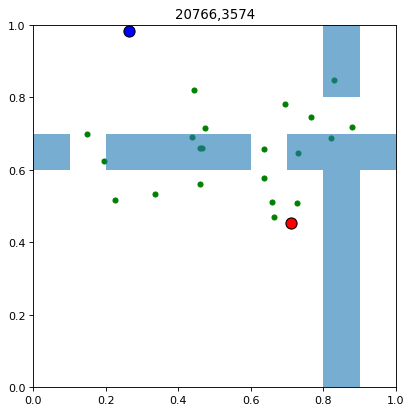

In [165]:
#net = CVAE()
#net.load_state_dict(torch.load(
#      "/home/zhizuo/lego/Model/lego2dCVAE_2019_12_27_16.pkl"))
num_viz = 20
# sample points of landmark
#vizIdx = randint(0, numTest - 1)
vizIdx = np.random.choice(range(4297))
#vizIdx = 88
print(vizIdx)
#c_sample_seed = data[numTrain + vizIdx, 2:]
c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
path = data[numTrain + vizIdx, 0:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))
c_sample_seed = torch.FloatTensor(c_sample_seed)
#print(y_viz)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    z = z.view(1, 2, 1,-1)
    tmp = c_sample_seed[0:4]
    tmp = tmp.view(1, 4, 1, -1)
    z = torch.cat((z, tmp), 1)
    z_deconv = net.deconv_de(z)
    c = c_sample_seed[4:104].view(1, 1, 10, 10)
    y = net.decoder(torch.cat((z_deconv, c),1))
    y = y.view(1, 64)
    predict = net.predict_mlp(y)
    y_viz[i,:] = predict
    
y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(path[0], path[1], color = 'green', s = 20)
plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

print(init[0], init[1])
print(goal[0], goal[1])
plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


# Train for DOF Landmark Dataset

In [ ]:
ratioTestTrain = 0.8
numEntries = landmark_data.shape[0]
numTrain = int(numEntries * ratioTestTrain)
X_train = landmark_data[0:numTrain,100:102]
c_train = landmark_data[0:numTrain,0:100]
X_test = landmark_data[numTrain:numEntries,100:102]
c_test = landmark_data[numTrain:numEntries,0:100]
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)

net = CVAE_MLP()
#resume = "/home/zhizuo/lego/Model/lego2dCVAE_2020_3_4_0.pkl"
#resume == None
#if resume == None:
#    net = CVAE_CNN()
#else:
#    net.load_state_dict(torch.load(resume))
if(torch.cuda.is_available()):
    net.cuda()
net.train()

optimizer = optim.Adam(net.parameters(), lr = opt.lr, betas=(opt.b1,opt.b2), 
                       eps = opt.eps, weight_decay = 0)

for epoch in range(opt.n_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0.0
    epoch_loss = 0.0
    for x, c in train_loader:
        i += 1
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / i
    print("Average loss of epoch {} Recon = {:.8f}, KL = {:.8f}, Loss = {:.6f}".
         format(epoch + 1, i, recon_loss, kl_loss, loss))
    if(epoch + 1)%1000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(),
                  '/home/zhizuo/lego/Model/lego2d_CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE_CNN")
net.eval()

Starting the 1 epoch
Average loss of epoch 1 Recon = 682.00000000, KL = 0.38783458, Loss = 99.956390
Starting the 2 epoch
Average loss of epoch 2 Recon = 682.00000000, KL = 0.24451275, Loss = 97.403694
Starting the 3 epoch
Average loss of epoch 3 Recon = 682.00000000, KL = 0.21331200, Loss = 120.112122
Starting the 4 epoch
Average loss of epoch 4 Recon = 682.00000000, KL = 0.20904623, Loss = 122.604774
Starting the 5 epoch
Average loss of epoch 5 Recon = 682.00000000, KL = 0.18860741, Loss = 128.703003
Starting the 6 epoch
Average loss of epoch 6 Recon = 682.00000000, KL = 0.16114922, Loss = 120.740425
Starting the 7 epoch
Average loss of epoch 7 Recon = 682.00000000, KL = 0.15579909, Loss = 129.371063
Starting the 8 epoch
Average loss of epoch 8 Recon = 682.00000000, KL = 0.15855339, Loss = 127.962807
Starting the 9 epoch
Average loss of epoch 9 Recon = 682.00000000, KL = 0.13281532, Loss = 114.815910
Starting the 10 epoch
Average loss of epoch 10 Recon = 682.00000000, KL = 0.11393926

In [4]:
a = np.array([[4, 3],
              [3, 5]])
b = np.linalg.inv(a)
print(b)

[[ 0.45454545 -0.27272727]
 [-0.27272727  0.36363636]]
